# An Overview of Variational Autoencoders in pytorch (WIP)

This notebook implements a Variational Autoencoder (VAE) in pytorch. VAEs are described in detail in this [tutorial](https://arxiv.org/abs/1606.05908). This is an implementation of a VAE as described in the paper, using both fully connected layers and convolution layers. There are a number of changes that can be made. Of particular interest are the following:
* Using the labels in order to implement a Conditional VAE (CVAE) as described in the tutorial above. This type of VAE uses extra information (the labels) as part of the encoding and decoding process.
* Using Inverse Autoregressive Flow modules as described in [IVF](https://arxiv.org/abs/1606.04934). This allows us to model more complex distributions. In particular, it provides an efficient way to have non-diagonal covariance matrices.
* Using an an [adversarial model](https://arxiv.org/abs/1512.09300) to measure the difference between images rather than using a per-pixel difference such as the BCE used in this notebook.

In [254]:
##Import relevant libraries
#Libraries used to create network
import torch as t
import torch.nn as nn
import torch.nn.functional as F

#Libraries used to retrieve data set and load it
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor

file_path = './models/{0}-{1}.pkl'

## Loss functions

The first loss function is defined by how well the image is reconstructed by the network. The more similar each pixel is in the original image is to the same pixel in the reconstructed image, the smaller this loss will be. This loss forces each image reconstruction to be similar to the input image.

The second loss function is the KL Divergence of the encoded mean and variance from the standard normal distribution. This imposes structure on the latent space by pushing the latent representation towards being a standard normal. The further the encoded means and variances are from a $N(0, 1)$ distribution, the more the encoding is penalized. 

In [255]:
bce = nn.BCEWithLogitsLoss(reduction='sum')

def KL(means, variances, minimum=1., epsilon=1e-8):
    '''
    Computes the KL divergence of N(means, variances) with N(0, 1) on a batch,
    then returns the mean of the batch.

    :param means: (torch.Tensor)
    :param variances: (torch.Tensor)
    :param minimum: (float, optional) Minimum value allows for each KL divergence.
    :param epsilon: (float, optional)
    :return: The KL divergence
    '''
    loss = t.sum(variances+means.pow(2)-t.log(variances+epsilon)-1,1)/2.
    minimum = minimum*t.ones_like(loss)
    stack = t.stack([loss, minimum])
    return t.max(stack).mean()

## Utility Layers

This creates the latent layer and a Reshape layer. The latter is exactly as it sounds; it reshapes the input that passes through it.

The former layer is what differentiates this from an autoencoder.

In [256]:
class LatentLayer(nn.Module):
    '''
    Creates a layer that takes an input and outputs a sample of latent variables. This is intended to
    be a connecting layer, and so it has two fully connected layers - one learns the means in the
    latent space, while the other learns the variances. The output for the variance has a softplus
    activator as it must be positive.
    '''
    def __init__(self, input_size, latent_size):
        super(LatentLayer, self).__init__()
        self.layer_mu = nn.Linear(input_size, latent_size)
        self.layer_var = nn.Linear(input_size, latent_size)
        
    def forward(self, x):
        #Compute statistic parameters
        mu = self.layer_mu(x)
        var = F.softplus(self.layer_var(x))
        #Create sample
        samples = mu+t.randn_like(mu)*var.sqrt()
        return samples, mu, var

class ReshapeLayer(nn.Module):
    '''
    Reshapes the input to be the output using view. Shapes are checked
    on forward pass to verify that they are compatible.

    :param view_shape: The shape to cast the input to. Given a batch
        input of shape (n, _) will be cast to (n, view_shape).
    '''
    def __init__(self, view_shape):
        super(ReshapeLayer, self).__init__()
        self.view_shape = view_shape

    def forward(self, x):
        '''
        Reshapes x to initialized shape. Assumes that x.shape[0] is
        the batch size.

        :param x: (torch.tensor)
        :return: (torch.tensor)
        '''
        output_shape = (x.shape[0],) + self.view_shape
        assert self.dimension(x.shape) == self.dimension(output_shape), '{0} and {1} are not compatabile'.format(x.shape, output_shape)
        return x.view(output_shape)

    @staticmethod
    def dimension(shape):
        #Helper function for checking dimensions
        out = 1
        for s in shape:
            out *= s
        return out

## VAE Class

This implements the class itself. In particular, we have an encoder network, a latent layer, and a decoder network. The former 

In [257]:
class VAE(nn.Module):
    '''
    Creates a Variation Autoencoder in Torch.
    '''
    def __init__(self, encoder_network, latent_layer, decoder_network):
        super(VAE, self).__init__()
        
        self.add_module('encoder', encoder_network)
        self.add_module('latent', latent_layer)
        self.add_module('decoder', decoder_network)
        
    def forward(self, x):
        '''
        Passes forward through encoder to create a sample latent
        representation, then decodes that representation.
        
        :param x: (torch.Tensor) 
        :return: (torch.Tensor) Reconstruction of x and it's representation in the latent space
        '''
        #encode
        x = self.encoder(x)
        #Sample from a normal distribution with mean mu and variance var
        z, mu, var = self.latent(x)
        #Decode and return latent variables
        return self.decoder(z), (mu, var)

## Loading the data

Here we use the torch tools to load the MNIST (or FashionMNIST) dataset. The `compose_train` is the functions we apply to the images before passing them to the model. Here we only call ToTensor to convert the image (with values between $[0, 255]$) to a tensor (with values between $[0, 1]$).

We also call DataLoader, which handles batching our data and performing the necessary transformations.

Note that for the FashionMNIST data, we use a RandomHorizontalFlip transformation. This increases the number of examples, which has a positive effect on fitting.

In [258]:
batch_size = 128
compose_train = Compose([RandomRotation(5), ToTensor()])
training_set = datasets.MNIST(root='./', train=True, download=True, transform=compose_train)
train_loader = t.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

testing_set = datasets.MNIST(root='./', train=False, download=True, transform=ToTensor())

data_name = 'MNIST'

## Building the network

A basic variational autoencoder can be broken down into three modules: the encoder network, the latent layer, and the decoder network. 

To build the networks, we use the Sequential object to build both the encoder and the decoder. To fit them together, we use the latent layer and the VAE class defined earlier. Each network uses SELU activation functions (see [here](https://arxiv.org/abs/1706.02515)).

The sizes of the hidden layers are chosen after some experimentation.

In [259]:
# We name the network here for convenience.
model_name = 'flat_vae_model'
latent_dim = 32

#Build networks
encoder_net = nn.Sequential(
    ReshapeLayer((28**2,)),
    nn.utils.weight_norm(nn.Linear(28**2, 256)),
    nn.SELU(),
    nn.utils.weight_norm(nn.Linear(256, 128)),
    nn.SELU(),
    nn.utils.weight_norm(nn.Linear(128, 64)),
    nn.SELU(),
)

latent_net = LatentLayer(64, latent_dim)

decoder_net = nn.Sequential(
    nn.utils.weight_norm(nn.Linear(latent_dim, 64)),
    nn.SELU(),
    nn.utils.weight_norm(nn.Linear(64, 128)),
    nn.SELU(),
    nn.utils.weight_norm(nn.Linear(128, 256)),
    nn.SELU(),
    nn.utils.weight_norm(nn.Linear(256, 28**2)),
    ReshapeLayer((1, 28, 28)),
)

model = VAE(encoder_net, latent_net, decoder_net)

## Training

The model is called in training mode explicitely using `model.train(True)` and then moved to the gpu using `model.cuda(0)`. Removing the last command makes it run on the cpu instead. If the model is going to be moved to the gpu, it should be done before loading the parameters into the optimizer.

Adam is used to optimize the model. SGD can also be used, but Adam has been more effective in my experience.

To train the model, we iterate through the data set. We have to send the inputs to the gpu before we can pass it through the model. We keep a running average of the total loss for summary at the end. The last three lines of the inner loop are needed in pytorch. `optimizer.zero_grad()` zeros out all derivatives. `loss.backward()` uses autodifferentiation to compute derivatives starting at loss. `optimizer.step()` optimizes the model parameters based on the derivatives from the previous step.

If the file have a pretrained model available, then that can be loaded by using the second code block instead.

In [265]:
epochs = 20
learning_rate = 1e-4

#Add to gpu before making the optimizer
model.train(True)
model.cuda(0)
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

epoch_summary_text = '\rEpoch {0}/{1}'
loss_summary_text = '{0} loss: {1:.5}'

percent_complete = '\r{0:.1%}'

n_data = len(training_set)
for epoch in range(epochs):
    average_latent = 0
    average_recon = 0
    
    for n_batch, (x, _) in enumerate(train_loader):
        x = x.cuda()
        
        x_pred, (mu, var) = model(x)
        
        #compute loss
        latent_loss = KL(mu, var)
        recon_loss = bce(x_pred, x)/batch_size
        loss = recon_loss+latent_loss
        
        #Compute average
        average_latent += (latent_loss-average_latent)/(n_batch+1)
        average_recon += (recon_loss-average_recon)/(n_batch+1)

        #Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Print percent complete
        print(percent_complete.format(batch_size*n_batch/n_data), end='')

    #Create summary loss
    epoch_summary = epoch_summary_text.format(epoch+1, epochs)
    latent_summary = loss_summary_text.format('latent', average_latent)
    recon_summary = loss_summary_text.format('recon', average_recon)
    total_summary = loss_summary_text.format('total', average_latent+average_recon)
    print(epoch_summary, recon_summary, latent_summary, total_summary, sep=' - ')
    
t.save(model.state_dict(), file_path.format(data_name, model_name))

Epoch 1/20 - recon loss: 128.47 - latent loss: 11.566 - total loss: 140.03
Epoch 2/20 - recon loss: 126.2 - latent loss: 11.71 - total loss: 137.91
Epoch 3/20 - recon loss: 124.24 - latent loss: 11.845 - total loss: 136.09
Epoch 4/20 - recon loss: 122.57 - latent loss: 12.019 - total loss: 134.59
Epoch 5/20 - recon loss: 121.17 - latent loss: 12.138 - total loss: 133.31
Epoch 6/20 - recon loss: 119.93 - latent loss: 12.234 - total loss: 132.16
Epoch 7/20 - recon loss: 118.83 - latent loss: 12.316 - total loss: 131.14
Epoch 8/20 - recon loss: 117.83 - latent loss: 12.412 - total loss: 130.24
Epoch 9/20 - recon loss: 116.92 - latent loss: 12.516 - total loss: 129.44
Epoch 10/20 - recon loss: 116.07 - latent loss: 12.601 - total loss: 128.67
Epoch 11/20 - recon loss: 115.4 - latent loss: 12.682 - total loss: 128.08
Epoch 12/20 - recon loss: 114.64 - latent loss: 12.768 - total loss: 127.41
Epoch 13/20 - recon loss: 114.01 - latent loss: 12.855 - total loss: 126.87
Epoch 14/20 - recon loss

# Image Generation

## Image Reconstruction

A VAE can be used to reconstruct examples. This is shown below. The images in the top row are the originals, while the images in the bottom row are the reconstructions. This VAE tends to blur examples together. That is, images tend towards their most generic, with colors and edges being blurred. There are a few ways to approach fixing this, which are mentioned above.

In [261]:
import matplotlib.pylab as plt
from random import sample

def image_plot(axis, image):
    axis.imshow(image.view(28,28), cmap='Greys')

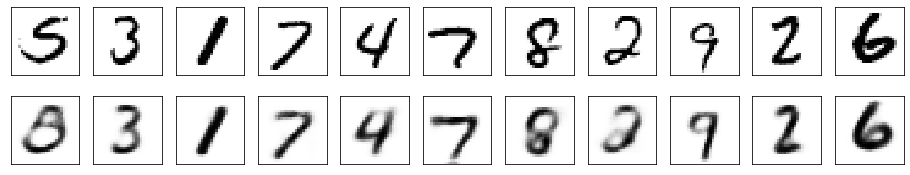

In [270]:
#Set up picture
n_images = 11
ax_settings = {'aspect':'equal', 'xticklabels':[], 'yticklabels':[], 'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(2, n_images, subplot_kw=ax_settings, figsize=(n_images*3//2, 3))


model.cpu()
model.eval()
with torch.no_grad():
    image_sample = sample(list(testing_set), n_images)
    #Find the mean in latent space
    for index, (image, _) in enumerate(image_sample):
        image = image.view((1,)+image.shape)
        recon_image, _ = model(image)

        image_plot(ax[0, index], image)
        image_plot(ax[1, index], t.sigmoid(recon_image))

## Latent Sampling

My interest in VAE are mostly tied to the fact that you can use them to generate new images. In this portion, we sample a random variable and use that to create a new image. That is, once a network is trained, we can use it to create new images.

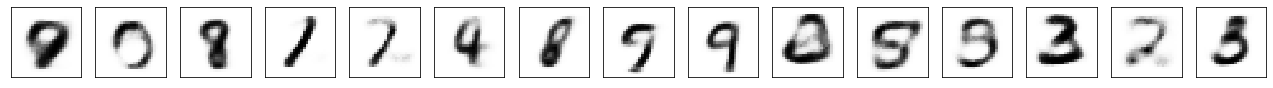

In [269]:
n_images = 15
fig, ax = plt.subplots(1, n_images, subplot_kw=ax_settings, figsize=(n_images*3/2, 3/2))
with torch.no_grad():
    for index in range(n_images):
        latent_sample = t.randn(1, latent_dim)
        image = model.decoder(latent_sample)
        image_plot(ax[index], t.sigmoid(image))

## Distribution of examples in the latent space

Below we can see a scatter plot of the means of each example. The groups tend towards being distributed in an elliptic manner. This is due to our diagonal assumption on variance. Using IVF can improve the distribution of the examples.

Note: The plot is fairly meaningless unless the latent dimension is equal to 2. To get around this, you can use a dimension reduction technique (e.g. t-SNE, umap) to reduce to two dimensions.

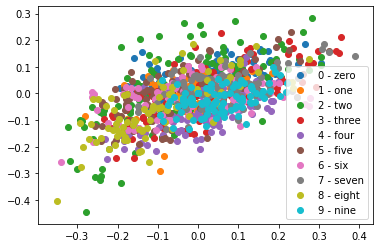

In [268]:
fig, ax = plt.subplots(1, 1)
n_images = len(testing_set)//10

outputs = t.zeros((10, 2, n_images))
with torch.no_grad():
    for index in range(n_images):
        image, label = testing_set[index]
        _, (mean, _) = model(image)
        outputs[label, 0, index] = mean[0][0]
        outputs[label, 1, index] = mean[0][1]
        
    for index, label in enumerate(testing_set.classes):
        ax.scatter(outputs[index, 0, :], outputs[index, 1, :], label=label)
    ax.legend()